In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score, plot_roc_curve, RocCurveDisplay, roc_curve
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [2]:
df = pd.read_csv("../data/FULL_Shot_Data.csv")
df.head()

,Unnamed: 0,id,minute,result,X,Y,xG,player,h_a,player_id,...,season,shotType,match_id,h_team,a_team,h_goals,a_goals,date,player_assisted,lastAction
0,0,14642,83,BlockedShot,0.795,0.321,0.047510,Harry Kane,a,647,...,2014,RightFoot,4754,West Ham,Tottenham,0,1,2014-08-16 15:00:00,Andros Townsend,Pass
1,1,15400,81,OwnGoal,0.029,0.582,0.000000,Harry Kane,a,647,...,2014,OtherBodyPart,4724,Sunderland,Tottenham,2,2,2014-09-13 15:00:00,NaN,Foul
2,2,16333,68,SavedShot,0.906,0.469,0.435830,Harry Kane,h,647,...,2014,LeftFoot,4715,Tottenham,Newcastle United,1,2,2014-10-26 13:30:00,Danny Rose,Pass
3,3,16901,58,SavedShot,0.917,0.463,0.085788,Harry Kane,a,647,...,2014,Head,4657,Aston Villa,Tottenham,1,2,2014-11-02 16:00:00,Erik Lamela,Cross
4,4,16909,89,Goal,0.761,0.415,0.067692,Harry Kane,a,647,...,2014,RightFoot,4657,Aston Villa,Tottenham,1,2,2014-11-02 16:00:00,NaN,Standard


In [3]:
# Find dominant foot
def get_top_style(row):
    return row['shotType'].value_counts().idxmax()
def replace_na(r):
    if r not in ['RightFoot', 'LeftFoot']:
        return None
    return r
dominant_foot = df.groupby('player_id').apply(get_top_style)
df2 = dominant_foot.apply(replace_na)
df_dict = df2.to_dict()
df['dominant_foot'] = df['player_id'].apply(lambda x: df_dict[x])
df['is_dominant'] = (df['dominant_foot'] == df['shotType']).astype(int)
df['is_foot'] = (df['shotType'].isin(['RightFoot', 'LeftFoot'])).astype(int)
pd.set_option('display.max_columns', None)
df.head()

,Unnamed: 0,id,minute,result,X,Y,xG,player,h_a,player_id,situation,season,shotType,match_id,h_team,a_team,h_goals,a_goals,date,player_assisted,lastAction,dominant_foot,is_dominant,is_foot
0,0,14642,83,BlockedShot,0.795,0.321,0.047510,Harry Kane,a,647,OpenPlay,2014,RightFoot,4754,West Ham,Tottenham,0,1,2014-08-16 15:00:00,Andros Townsend,Pass,RightFoot,1,1
1,1,15400,81,OwnGoal,0.029,0.582,0.000000,Harry Kane,a,647,SetPiece,2014,OtherBodyPart,4724,Sunderland,Tottenham,2,2,2014-09-13 15:00:00,NaN,Foul,RightFoot,0,0
2,2,16333,68,SavedShot,0.906,0.469,0.435830,Harry Kane,h,647,OpenPlay,2014,LeftFoot,4715,Tottenham,Newcastle United,1,2,2014-10-26 13:30:00,Danny Rose,Pass,RightFoot,0,1
3,3,16901,58,SavedShot,0.917,0.463,0.085788,Harry Kane,a,647,FromCorner,2014,Head,4657,Aston Villa,Tottenham,1,2,2014-11-02 16:00:00,Erik Lamela,Cross,RightFoot,0,0
4,4,16909,89,Goal,0.761,0.415,0.067692,Harry Kane,a,647,DirectFreekick,2014,RightFoot,4657,Aston Villa,Tottenham,1,2,2014-11-02 16:00:00,NaN,Standard,RightFoot,1,1


In [4]:
attack_df = df[(df['result'] != 'OwnGoal')].copy()

In [5]:
attack_df['outcome'] = (attack_df['result'] == 'Goal').astype(int)

In [6]:
attack_df.columns

Index(['Unnamed: 0', 'id', 'minute', 'result', 'X', 'Y', 'xG', 'player', 'h_a',
       'player_id', 'situation', 'season', 'shotType', 'match_id', 'h_team',
       'a_team', 'h_goals', 'a_goals', 'date', 'player_assisted', 'lastAction',
       'dominant_foot', 'is_dominant', 'is_foot', 'outcome'],
      dtype='object')

In [7]:
input_data = attack_df[['X', 'Y', 'situation', 'shotType', 'is_foot', 'is_dominant', 'outcome']].copy()
input_data_encoded = pd.concat([
        input_data[['X', 'Y', 'is_foot', 'is_dominant']],
        pd.get_dummies(input_data['situation']),
        pd.get_dummies(input_data['shotType'])
        ], axis=1)
output_data = input_data['outcome']
input_data_encoded.head()

,X,Y,is_foot,is_dominant,DirectFreekick,FromCorner,OpenPlay,Penalty,SetPiece,Head,LeftFoot,OtherBodyPart,RightFoot
0,0.795,0.321,1,1,0,0,1,0,0,0,0,0,1
2,0.906,0.469,1,0,0,0,1,0,0,0,1,0,0
3,0.917,0.463,0,0,0,1,0,0,0,1,0,0,0
4,0.761,0.415,1,1,1,0,0,0,0,0,0,0,1
5,0.981,0.558,0,0,0,0,1,0,0,1,0,0,0


In [8]:
X_train, X_test, y_train, y_test = train_test_split(input_data_encoded.values, output_data.values, random_state=0, test_size=0.3)

In [9]:
reg = XGBClassifier(scale_pos_weight=1, use_label_encoder=False)
reg.fit(X_train, y_train)

[17:06:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [10]:
y_pred = reg.predict(X_test)

In [11]:
y_pred, y_test

(array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]))

In [12]:
print("Test", accuracy_score(y_pred, y_test), "Train", accuracy_score(reg.predict(X_train), y_train), "ROC AUC Score", roc_auc_score(y_test, y_pred), "PR AUC Score", average_precision_score(y_test, y_pred))
       

Test 0.9044624764091459 Train 0.9072966908448447 ROC AUC Score 0.5868973387197064 PR AUC Score 0.21253147242191567


In [13]:
p_vals = reg.predict_proba(input_data_encoded.values)[:,1]
p_vals

array([0.02670815, 0.23582032, 0.06503119, ..., 0.03520205, 0.01476549,
       0.09648322], dtype=float32)

In [14]:
pred = list(p_vals)
attack_df['prediction'] = pred

In [15]:
attack_df[['xG', 'prediction', 'outcome']]

,xG,prediction,outcome
0,0.047510,0.026708,0
2,0.435830,0.235820,0
3,0.085788,0.065031,0
4,0.067692,0.214129,1
5,0.594700,0.353150,0
...,...,...,...
384458,0.014314,0.017101,0
384459,0.017178,0.015631,0
384460,0.020250,0.035202,0
384461,0.012068,0.014765,0


In [16]:
attack_df.iloc[0]

Unnamed: 0                           0
id                               14642
minute                              83
result                     BlockedShot
X                                0.795
Y                                0.321
xG                             0.04751
player                      Harry Kane
h_a                                  a
player_id                          647
situation                     OpenPlay
season                            2014
shotType                     RightFoot
match_id                          4754
h_team                        West Ham
a_team                       Tottenham
h_goals                              0
a_goals                              1
date               2014-08-16 15:00:00
player_assisted        Andros Townsend
lastAction                        Pass
dominant_foot                RightFoot
is_dominant                          1
is_foot                              1
outcome                              0
prediction               

In [17]:
from sklearn.metrics import plot_confusion_matrix

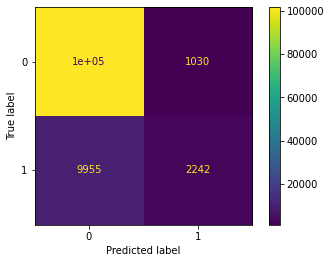

In [18]:
plot_confusion_matrix(reg, X_test, y_test)

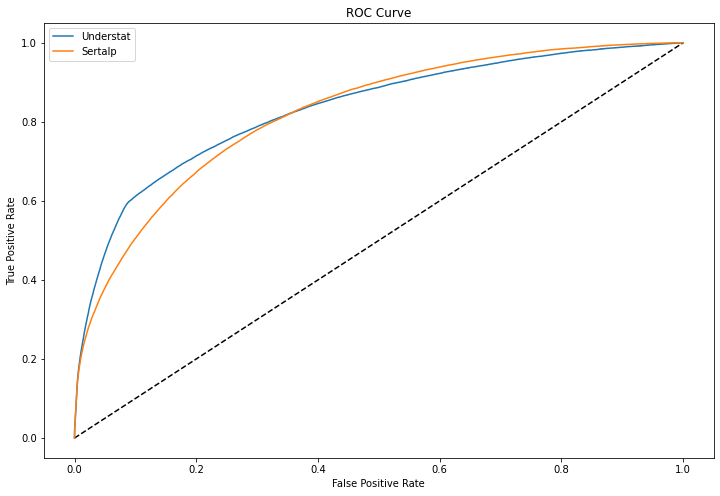

In [19]:
understat_fpr, understat_tpr, understat_thresholds = roc_curve(attack_df['outcome'], attack_df['xG'])
my_fpr, my_tpr, my_thresholds = roc_curve(attack_df['outcome'], attack_df['prediction'])
plt.figure(figsize=(12,8))
plt.plot([0,1],[0,1], 'k--')
plt.plot(understat_fpr, understat_tpr, label='Understat')
plt.plot(my_fpr, my_tpr, label='Sertalp')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [20]:
attack_df['prediction'].sum(), attack_df['outcome'].sum(), attack_df['xG'].sum()

(40349.98302480439, 40440, 41271.08703612303)

In [21]:
roc_auc_score(attack_df['outcome'], attack_df['prediction'])

0.8213902756223154

In [22]:
roc_auc_score(attack_df['outcome'], attack_df['xG'])

0.8316771452873846